In [132]:
import pandas as pd
import seaborn as sns
import spotipy

from dotenv import dotenv_values
from matplotlib import pyplot
from time import sleep
from spotipy.oauth2 import SpotifyOAuth


In [68]:
config = dotenv_values(".env")

In [69]:
scope = "user-modify-playback-state app-remote-control streaming user-read-playback-state"

sp = spotipy.Spotify(
    auth_manager=SpotifyOAuth(
        client_id=config["CLIENT_ID"],
        client_secret=config["CLIENT_SECRET"],
        redirect_uri=config["REDIRECT_URL"],
        scope=scope
    )
)


In [ ]:
devices_df = pd.DataFrame(sp.devices()["devices"])
device_id = devices_df[devices_df["name"] == "Tim’s MacBook Pro (2)"]["id"].values[0]

In [154]:
def play_middle_of_track(device_id: str, track_series: pd.Series, n_seconds: int=12) -> None:
    """Play n_seconds on device starting from the middle of the track"""
    sp.start_playback(
        device_id=device_id,
        uris=[track_series["uri"]],
        position_ms=track_series["duration_ms"] / 2
    )
    sleep(n_seconds)
    sp.pause_playback(device_id=device_id)

def play_audio_feature_extremes(tracks_df, audio_feature, pause_seconds: int=2) -> None:
    """"""
    max_track = tracks_df.sort_values(by=audio_feature, ascending=False).iloc[0]
    print(f"Playing track with highest {audio_feature}({max_track[audio_feature]}): {max_track['artist_names']} - {max_track['name']}")
    play_middle_of_track(device_id, max_track)

    sleep(pause_seconds)
    
    min_track = tracks_df.sort_values(by=audio_feature, ascending=True).iloc[0]
    print(f"Playing track with lowest {audio_feature}({min_track[audio_feature]}): {min_track['artist_names']} - {min_track['name']}")
    play_middle_of_track(device_id, min_track)

In [70]:
df_apres_ski = pd.read_pickle("data/df_apres_ski.pkl")
df_top_2000 = pd.read_pickle("data/df_top_2000.pkl")

In [73]:
df_apres_ski.columns

Index(['id', 'artists', 'name', 'album', 'external_urls', 'popularity',
       'album_id', 'artist_names', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature', 'album_genres', 'album_name',
       'album_release_date'],
      dtype='object')

In [98]:
df_apres_ski.head(1).T

,0
id,5Qht2aUJcCjRuhrlHvvKt2
artists,[{'external_urls': {'spotify': 'https://open.s...
name,Johnny Däpp
album,"{'album_type': 'single', 'artists': [{'externa..."
external_urls,{'spotify': 'https://open.spotify.com/track/5Q...
popularity,0
album_id,0LRp6zGzCjKshI2cxREBMU
artist_names,Lorenz Büffel
danceability,0.752
energy,0.858


In [117]:
df_all_songs = (
    pd.concat(
        [
            df_apres_ski.assign(playlist="Après Ski"),
            df_top_2000.assign(playlist="Top 2000"),
        ]
    )
    .assign(duration_minutes=lambda track: track["duration_ms"] / 1000 / 60)
)

In [118]:
zero_to_one_scale = [
    'acousticness',
    'danceability',
    'energy',
    'instrumentalness',
    'liveness',
    'speechiness',
    'valence',
]
other_features = ['duration_minutes', 'key', 'loudness', 'popularity', 'tempo']

In [119]:
df_to_melt = df_all_songs[["id", "playlist"] + zero_to_one_scale + other_features]
df_to_melt.head()

,id,playlist,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,duration_minutes,key,loudness,popularity,tempo
0,5Qht2aUJcCjRuhrlHvvKt2,Après Ski,0.0378,0.752,0.858,0.000000,0.0541,0.1260,0.731,3.727867,10,-2.901,0,132.003
1,5CXXhWWF7klSG0fLsBmvPG,Après Ski,0.1450,0.600,0.954,0.000000,0.4130,0.2670,0.642,3.315067,6,-2.130,0,144.976
2,1cSXzDZt8vzuUp2XREQEJN,Après Ski,0.0419,0.798,0.740,0.000002,0.1570,0.0458,0.834,3.662000,11,-4.865,67,128.054
3,1TD5Z9V208btoYDiKPJwVC,Après Ski,0.1370,0.606,0.985,0.000023,0.4960,0.0428,0.915,3.766450,8,-2.594,1,154.048
4,5Yt86VvCVKE3U6C3yEIm0C,Après Ski,0.5050,0.465,0.875,0.000000,0.0577,0.1290,0.724,3.366450,9,-6.023,0,131.064


In [120]:
df_to_melt.shape

(2284, 14)

In [121]:
melted_df = pd.melt(
    df_to_melt,
    id_vars=["id", "playlist"],
    value_vars=zero_to_one_scale + other_features,
    var_name="audio_feature",
    value_name="value",
)

In [122]:
melted_df.head()

,id,playlist,audio_feature,value
0,5Qht2aUJcCjRuhrlHvvKt2,Après Ski,acousticness,0.0378
1,5CXXhWWF7klSG0fLsBmvPG,Après Ski,acousticness,0.1450
2,1cSXzDZt8vzuUp2XREQEJN,Après Ski,acousticness,0.0419
3,1TD5Z9V208btoYDiKPJwVC,Après Ski,acousticness,0.1370
4,5Yt86VvCVKE3U6C3yEIm0C,Après Ski,acousticness,0.5050


In [123]:
melted_df.shape

(27408, 4)

<AxesSubplot: xlabel='audio_feature', ylabel='value'>

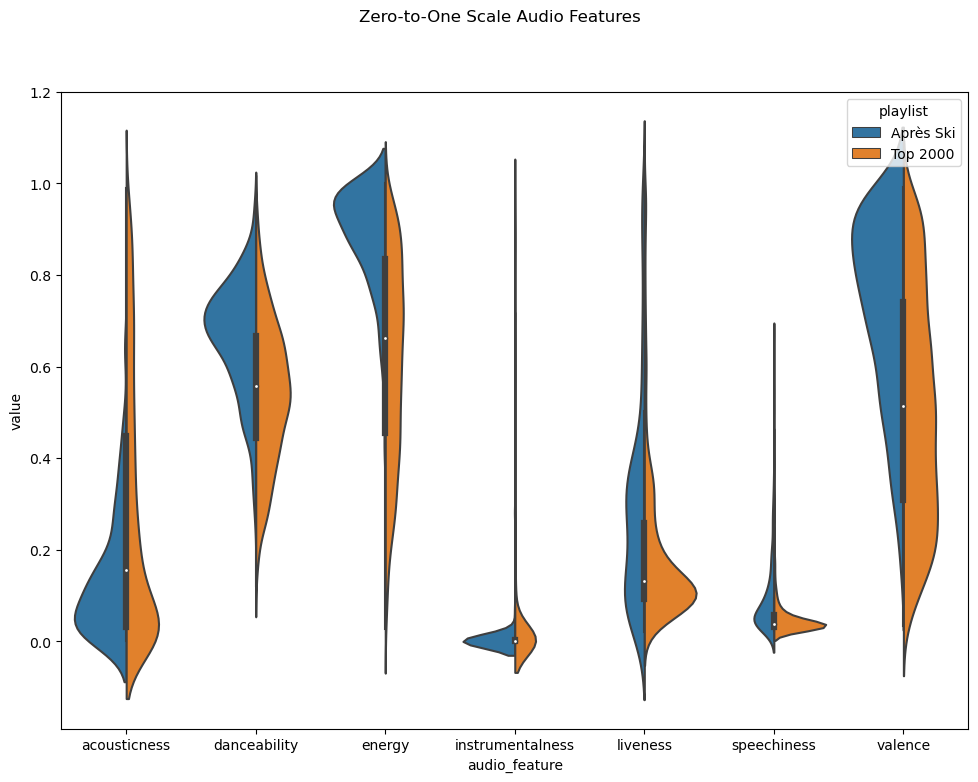

In [127]:
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
fig.suptitle('Zero-to-One Scale Audio Features')
sns.violinplot(ax=ax, data=melted_df[melted_df["audio_feature"].isin(zero_to_one_scale)], x="audio_feature", y="value", hue="playlist", split=True)

# What does this mean?!

In [159]:
play_audio_feature_extremes(df_apres_ski, "acousticness")
# https://mljar.com/blog/jupyter-notebook-insert-image/

# from IPython import display
# display.Image("URL-to-image")


Playing track with highest acousticness(0.784): Zware Jongens - We Heffen De Glazen
Playing track with lowest acousticness(0.000305): DJ Ötzi - Noch in 100.000 Jahren - Bassflow Remix


In [151]:
play_audio_feature_extremes(df_apres_ski, "danceability")

Playing track with highest danceability(0.941): Lil Kleine & Ronnie Flex - Stoff und Schnaps
Playing track with lowest danceability(0.271): Alex - Lala Medley


In [152]:
play_audio_feature_extremes(df_apres_ski, "energy")

Playing track with highest energy(1.0): Mickie Krause & Klaus & Klaus - Die Krankenschwester
Playing track with lowest energy(0.281): Andre Hazes - Ik Leef M'n Eigen Leven


In [155]:
play_audio_feature_extremes(df_apres_ski, "liveness")

Playing track with highest liveness(0.989): Kastelruther Spatzen & Markus Musshauser - Almenrausch und Pulverschnee - Après Ski Mix
Playing track with lowest liveness(0.0202): Django Wagner - Mooie Blauwe Ogen - Mooie Blauwe Ogen


In [157]:
play_audio_feature_extremes(df_apres_ski, "instrumentalness")

Playing track with highest instrumentalness(0.688): Frans Bauer - Heb Je Even Voor Mij
Playing track with lowest instrumentalness(0.0): Lorenz Büffel - Johnny Däpp


In [158]:
play_audio_feature_extremes(df_apres_ski, "speechiness")

Playing track with highest speechiness(0.417): John Travolta, Olivia Newton-John, Phil Harding & Ian Curnow - The Grease Mega-Mix - From 'Grease'
Playing track with lowest speechiness(0.0231): Liquido - Narcotic - Radio Edit


In [ ]:
play_audio_feature_extremes(df_apres_ski, "valence")

Playing track with highest valence(0.992): Lawineboys - Zuipen
Playing track with lowest valence(0.155): Andre Hazes - Zij Gelooft In Mij


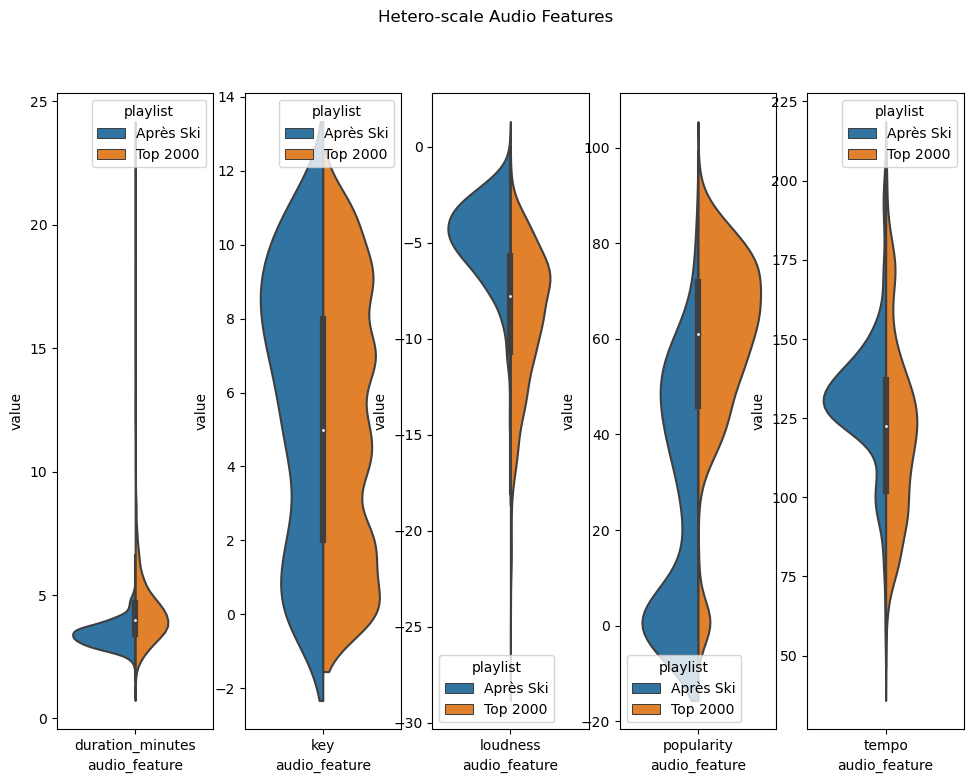

In [126]:
a4_dims = (11.7, 8.27)
fig, axs = pyplot.subplots(1, len(other_features), figsize=a4_dims)
fig.suptitle('Hetero-scale Audio Features')
for i, feature in enumerate(other_features):
    sns.violinplot(ax=axs[i], data=melted_df[melted_df["audio_feature"] == feature], x="audio_feature", y="value", hue="playlist", split=True)

In [ ]:
# Niet-woorden: in Hurra die Gams en in Atemlos durch die Nach

In [59]:
devices_df = pd.DataFrame(sp.devices()["devices"])
device_id = devices_df[devices_df["name"] == "Tim’s MacBook Pro (2)"]["id"].values[0]

In [61]:
track_uri = (
    df_apres_ski.sort_values(by="danceability", ascending=False)
    .head(1)
    ["uri"].values[0]
)

In [128]:
sp.start_playback(device_id=device_id, uris=[track_uri], position_ms=15 * 1000)